In [24]:
!pip install wwf

In [1]:
from fastai.vision.all import *

In [2]:
pwd

'C:\\Users\\hammad jamil'

In [11]:
import os
path=os.chdir('C:\\Users\\hammad jamil\\Desktop')

In [12]:
path=Path.cwd()
path

Path('C:/Users/hammad jamil/Desktop')

In [13]:
path=path/'pistol_data'
path.ls()

(#2) [Path('C:/Users/hammad jamil/Desktop/pistol_data/train'),Path('C:/Users/hammad jamil/Desktop/pistol_data/_annotations.json')]

In [14]:
imgs, lbl_bbox = get_annotations(path/'_annotations.json')

In [15]:
img2bbox = dict(zip(imgs, lbl_bbox))

In [16]:
first = {k: img2bbox[k] for k in list(img2bbox)[:1]}; first

{'armas (2178).jpg.rf.0095da5f53aa7d641eaeafc9c9b9b9ab.jpg': ([[5,
    3,
    405.40000000000003,
    398.2]],
  ['pistol'])}

In [17]:
getters = [lambda o: path/'train'/o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]]


In [18]:
item_tfms = [Resize(128, method='pad'),]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

In [19]:
def get_train_imgs(noop):  return imgs

In [20]:
pascal = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 get_items=get_train_imgs,
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [21]:
dls = pascal.dataloaders(path/'train')

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [22]:
dls.c = 1

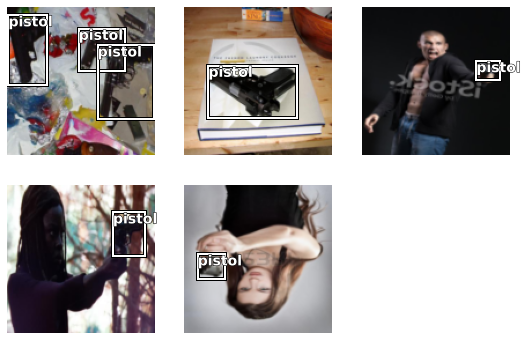

In [23]:
dls.show_batch(max_n=5)

In [25]:
from wwf.vision.object_detection import *

In [26]:
encoder = create_body(resnet34, pretrained=True)

In [27]:
get_c(dls)


1

In [28]:
arch = RetinaNet(encoder, get_c(dls), final_bias=-4)


In [29]:
create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(248, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=248, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

In [30]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

In [31]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)


In [32]:
TensorImage.register_func(torch.nn.functional.smooth_l1_loss, TensorImage, TensorBBox)
TensorMultiCategory.register_func(TensorMultiCategory.mul, TensorMultiCategory, TensorImage)
TensorImage.register_func(torch.nn.functional.binary_cross_entropy_with_logits, TensorImage, TensorMultiCategory)

In [33]:
def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [34]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)


In [35]:
learn.freeze()

In [36]:
learn.fit_one_cycle(9, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
0,2.803843,1.834994,18:19
1,1.887674,1.275832,16:31
2,1.519350,1.178693,27:43
3,1.323516,1.171001,21:08
4,1.239969,1.173403,16:28
5,1.171783,1.150463,22:10
6,1.134803,1.154323,22:01
7,1.112382,1.131602,22:09
8,1.087362,1.152759,29:03


In [40]:
learn.save('od.pkl')

Path('models/od.pkl.pth')

In [46]:
model=learn.load('od.pkl')